### Assigment 1
Yorick Juffer \
s1993623

**Libraries**

In [23]:
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Noise**

In [24]:
def noise(s):
    rand = random.uniform(0.001,0.999)
    return s * math.log((1 - rand)/rand)

**Time to Pulses**

In [25]:
def time_to_pulses(time, t_0 = 0.011, a = 1.1, b = 0.015, add_noise = True):
    
    pulses = 0
    pulse_duration = t_0
    
    while time >= pulse_duration:
        time = time - pulse_duration
        pulses = pulses + 1
        pulse_duration = a * pulse_duration + add_noise * noise(b * a * pulse_duration)
        
    return pulses

**Pulses to Time**

In [26]:
def pulses_to_time(pulses, t_0 = 0.011, a = 1.1, b = 0.015, add_noise = True):
    
    time = 0
    pulse_duration = t_0
    
    while pulses > 0:
        time = time + pulse_duration
        pulses = pulses - 1
        pulse_duration = a * pulse_duration + add_noise * noise(b * a * pulse_duration)
    
    return time

**Reaction Time Experiment**

<AxesSubplot: ylabel='average'>

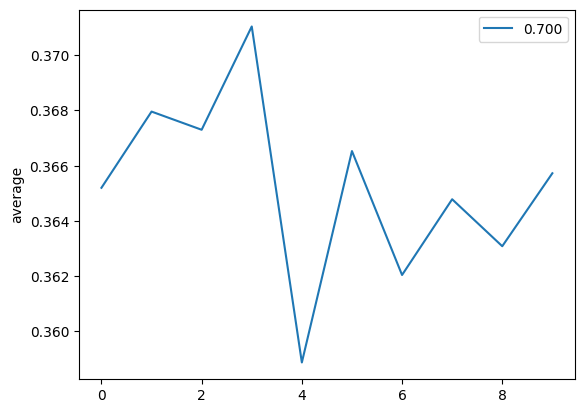

In [38]:
def reactionTime():
    return 0.38

def reaction(condition, participants = 100, training = 600, trials = 10):
    results = pd.DataFrame(index=range(trials), columns=range(participants))



    for participant in range(participants):

        goal_pulses = 0        
        
        # Train
        for i in range(training):
            goal_pulses += time_to_pulses(condition)
        goal_pulses = goal_pulses / training
        
        # Trials
        for trial in range(trials):

            if(trial == 9):
                condition =  0.467

            expectation  = pulses_to_time(goal_pulses)
            difference = condition - expectation

            if(difference > 0.05):
                reaction_time =  reactionTime() - difference
            elif(difference < -0.05):
                reaction_time =  reactionTime() + difference
            else: 
                reaction_time =  reactionTime()


            # if(expectation  <= condition - 0.05):
            #     reaction_time =  pulses_to_time(10) - 0.05
            # elif(expectation > condition + 0.05):
            #     reaction_time =  pulses_to_time(10) + 2
            # else:
            #     reaction_time = pulses_to_time(10)


            results.at[trial, participant] = reaction_time
            results["average"] = results.mean(axis=1)

    return results["average"]



# result_350 = reaction(0.350)
# result_467 = reaction(0.467)
result_700 = reaction(0.700)


# sns.lineplot(data=result_350, label="0.350")
# sns.lineplot(data=result_467, label="0.467")
sns.lineplot(data=result_700, label="0.700")


In [6]:
# def peak(t, reps = 10, n_training = 10, n_trials = 100):
#     results = pd.DataFrame(columns = ['rep', 'val'])
#     for rep in range(reps):
#         goal_pulses = 0
#         for i in range(n_training):
#             goal_pulses += time_to_pulses(t)
#         goal_pulses = goal_pulses / n_training
#         for i in range(n_trials):
#             val = pulses_to_time(goal_pulses)
#             results.loc[len(results)] = [rep, val]
#     return results['val']

# res21 = peak(21)
# res12 = peak(12)
# res8 = peak(8)

# sns.kdeplot(np.array(res21), label="21s")
# sns.kdeplot(np.array(res12), label="12s")
# sns.kdeplot(np.array(res8), label="8s")